In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
import pandas as pd
from scipy.stats import norm
import pymc as pm

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
dates = pd.date_range(start='1/1/2013', end='6/1/2014')

In [142]:
def draw_betas(betas, idx, sig):
    betas[idx+1] = norm(betas[idx], sig).rvs()
    return betas

def draw_mus(mus, idx, sig):
    mus[idx+1] = norm(mus[idx], sig).rvs()
    return mus
    
def make_betas_vector(n, sig=.01):
    betas = np.ones(n)
    for idx in range(n-1):
        betas = draw_betas(betas, idx, sig)
    return betas

def make_mus_vector(n, sig=1):
    mus = np.zeros(n)
    for idx in range(n-1):
        mus = draw_mus(mus, idx, sig)
    return mus

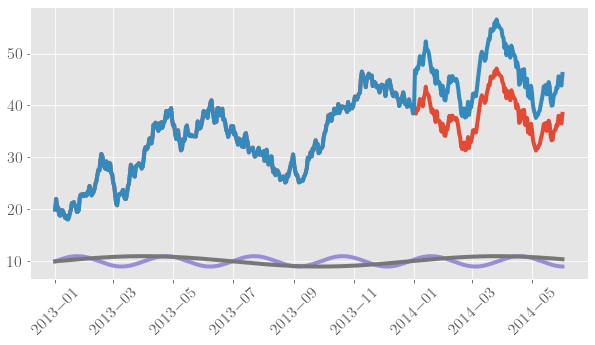

In [143]:
days = np.arange(0, len(dates), 1)
cov_1 = np.sin(2*np.pi/90 * days) + 10
cov_2 = np.sin(2*np.pi/360 * days) + 10
beta_1 = make_betas_vector(len(dates))
beta_2 = make_betas_vector(len(dates))
mus = make_mus_vector(len(dates))
eps = norm(0, .1).rvs(len(dates))
uplift = .2
data = beta_1*cov_1 + beta_2*cov_2 + mus + eps
plt.figure(figsize=(10, 5))
plt.plot(dates, data)
idx = int(np.argwhere(dates > '2014-01-01')[0])
data[idx:] = data[idx:] * (1 + uplift)
plt.xticks(rotation=45)
plt.plot(dates, data)
plt.plot(dates, cov_1)
plt.plot(dates, cov_2)

In [158]:
with pm.Model() as model:
    sig_1 = np.sqrt(pm.InverseGamma('sig1', 0.5, 0.5))
    sig_2 = np.sqrt(pm.InverseGamma('sig2', 0.5, 0.5))                
    sig_mu = np.sqrt(pm.InverseGamma('sig_mu', 0.5, 0.5))
    betas_1 = make_betas_vector(idx, sig_1.eval())
    print(betas_1)
    betas_2 = make_betas_vector(idx, sig_2.eval())
    mus =  make_mus_vector(idx, sig_mu.eval())
    eps = np.sqrt(pm.InverseGamma('sigma', 0.5, 0.5))
    like = pm.Normal('like', betas_1 * cov_1[:idx] + betas_2 * cov_2[:idx] + mus, eps, observed=data[:idx])
    traces = pm.sample(return_inferencedata=None, target_accept=.99, chains=1)


[  1.           3.03103389   7.20776471   2.05252926   2.58650377
   0.3054114   -2.7415108   -7.34635179  -9.38103305  -8.88031473
  -8.5621966  -11.97952271 -10.18038669  -7.91755956  -7.8333512
 -11.89291295 -15.02365966 -13.22384839 -12.96828397 -16.16392847
 -18.40647288 -20.3489642  -18.50505621 -19.15045065 -14.5535853
 -14.63312917 -20.13898763 -17.2198029  -22.11160786 -23.40692101
 -23.38475112 -23.28381111 -25.17028123 -26.91028158 -27.78801434
 -31.38773783 -30.7541018  -31.48385938 -35.0948894  -36.72783293
 -38.31058192 -42.65808872 -45.07898572 -43.92454856 -41.9656307
 -43.03784824 -39.69648099 -42.27776434 -42.29884951 -46.06271146
 -48.75689292 -45.85691744 -46.79494052 -48.63296146 -43.86011062
 -46.10656463 -47.08025921 -44.30077317 -44.5911876  -47.1017938
 -44.68219364 -40.68205042 -40.34976778 -40.1616807  -36.60450735
 -36.27049754 -35.66576905 -38.19680921 -38.2471697  -36.99828404
 -39.71378239 -40.1975013  -37.50552061 -39.30820382 -38.13425722
 -35.32258291 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sig1, sig2, sig_mu, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 10 seconds.


In [159]:
betas_1

array([  1.        ,   3.03103389,   7.20776471,   2.05252926,
         2.58650377,   0.3054114 ,  -2.7415108 ,  -7.34635179,
        -9.38103305,  -8.88031473,  -8.5621966 , -11.97952271,
       -10.18038669,  -7.91755956,  -7.8333512 , -11.89291295,
       -15.02365966, -13.22384839, -12.96828397, -16.16392847,
       -18.40647288, -20.3489642 , -18.50505621, -19.15045065,
       -14.5535853 , -14.63312917, -20.13898763, -17.2198029 ,
       -22.11160786, -23.40692101, -23.38475112, -23.28381111,
       -25.17028123, -26.91028158, -27.78801434, -31.38773783,
       -30.7541018 , -31.48385938, -35.0948894 , -36.72783293,
       -38.31058192, -42.65808872, -45.07898572, -43.92454856,
       -41.9656307 , -43.03784824, -39.69648099, -42.27776434,
       -42.29884951, -46.06271146, -48.75689292, -45.85691744,
       -46.79494052, -48.63296146, -43.86011062, -46.10656463,
       -47.08025921, -44.30077317, -44.5911876 , -47.1017938 ,
       -44.68219364, -40.68205042, -40.34976778, -40.16

In [157]:
traces['like']

KeyError: 'Unknown variable like'

(array([998.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([7.41615641e-02, 1.90740016e+04, 3.81479291e+04, 5.72218566e+04,
        7.62957840e+04, 9.53697115e+04, 1.14443639e+05, 1.33517566e+05,
        1.52591494e+05, 1.71665421e+05, 1.90739349e+05]),
 <BarContainer object of 10 artists>)

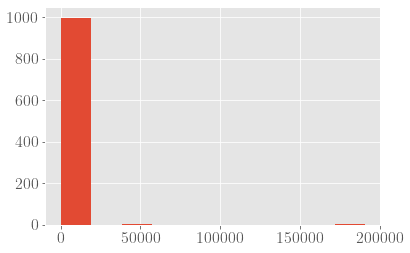

In [156]:
plt.hist(traces['sig1'
               ])

In [90]:
betas_1_mean = traces['betas1'].mean(axis=0)
betas_2_mean = traces['betas2'].mean(axis=0)
mus_mean = traces['mus'].mean(axis=0)
betas_1_full = np.concatenate([betas_1_mean, np.zeros(len(dates)-idx)])
betas_2_full = np.concatenate([betas_2_mean, np.zeros(len(dates)-idx)])
mus_full = np.concatenate([mus_mean, np.zeros(len(dates)-idx)])

for idx in range(idx, len(n_pred)):
    betas_1_full[idx] = norm(betas_1_full[idx], )

KeyError: 'Unknown variable betas1'

In [60]:
betas_1_full[idx]

0.0

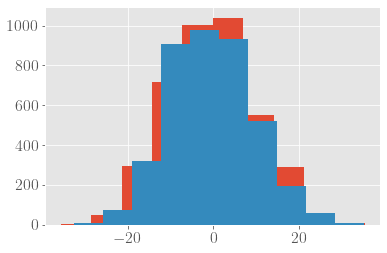

In [47]:
plt.hist(traces['mus'][:, 0]);
plt.hist(traces['mus'][:, 5]);